## Neural networks for segmentation

In [ ]:
! wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
! unzip -q data.zip

--2020-08-21 16:32:21--  https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/jy34yowcf85ydba/data.zip [following]
--2020-08-21 16:32:22--  https://www.dropbox.com/s/raw/jy34yowcf85ydba/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca903bf9b909ce3926b03daf2db.dl.dropboxusercontent.com/cd/0/inline/A97VxcxGUpSimjp0_6xoYvsAIF2G0FD30n8aHSCy8cLLbtVpaN6knXrC2izgJLZFJNy3cZJH2TbNiMot3JxmL9Za3TpjTwyHT28sp9U1ezcbcQ/file# [following]
--2020-08-21 16:32:22--  https://uca903bf9b909ce3926b03daf2db.dl.dropboxusercontent.com/cd/0/inline/A97VxcxGUpSimjp0_6xoYvsAIF2G0FD30n8aHSCy8cLLbtVpaN6knXrC2izgJLZFJNy3cZJH2TbNiMot3JxmL9Za3TpjTwyHT28sp9U1ezcbcQ/file
Resolving uca903bf9b909

Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [ ]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
import skimage.io as io
import skimage
%matplotlib inline

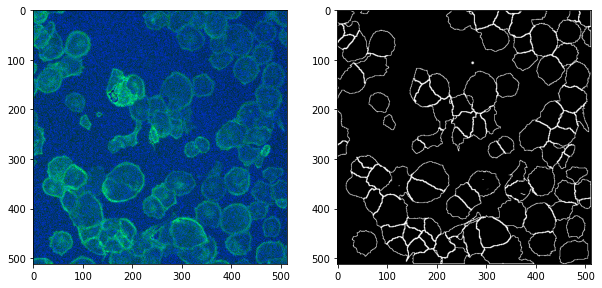

In [ ]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = skimage.img_as_ubyte(skimage.io.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp'))
plt.imshow(im)
plt.subplot(1,2,2)
mask = skimage.img_as_ubyte(skimage.io.imread('BBBC018_v1_outlines/train/00735-cells.png'))
plt.imshow(mask, 'gray')

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [ ]:
images_folder = 'BBBC018_v1_images-fixed'
outlines_folder = 'BBBC018_v1_outlines'
img_shape = (512, 512)

In [ ]:
from pathlib import Path
import pandas as pd

def get_labels(img_folder, masks_folder, sub_folder):
    img_folder = Path(img_folder).joinpath(sub_folder)
    masks_folder = Path(masks_folder).joinpath(sub_folder) 
    
    for bmp_file in img_folder.glob('**/*.bmp'):
        img_number = bmp_file.name.split('-')[0]
        
        for mask_file in masks_folder.glob(f'{img_number}*'):
            yield str(bmp_file), str(mask_file)
                    
train_IDs, train_labels = zip(*get_labels(images_folder, outlines_folder, 'train'))
test_IDs, test_labels = zip(*get_labels(images_folder, outlines_folder, 'val'))

In [ ]:
def binarize_mask(mask, threshold=80):
    for i in range(len(mask)):
        for j in range(len(mask[i])):
            if mask[i][j] > threshold:
                mask[i][j] = 255
            else:
                mask[i][j] = 0

def binarize_img(img, treshold=0.5):
    for i in range(len(img)):
        for j in range(len(img[i])):
            if img[i][j] > threshold:
                pass
            else:
                img[i][j] = 0

In [ ]:
import keras
from skimage import img_as_float, img_as_ubyte
from skimage.restoration import denoise_wavelet
import imgaug.augmenters as iaa
import math
from skimage.color import rgb2gray

seq = iaa.Sequential(
    [
        iaa.Fliplr(0.2),  
        iaa.Flipud(0.4),
        iaa.SomeOf(1, [
            iaa.ContrastNormalization((0.8, 1.3), per_channel=0.2),
            iaa.Multiply((0.8, 1.3), per_channel=0.2),
            iaa.GammaContrast(gamma=(0.8, 1.3)),
        ]),
        iaa.SomeOf(2, [
            iaa.Rot90((1, 3)),
            iaa.Crop(percent=(0, 0.08)),            
            iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),   
            iaa.Sometimes(0.5, iaa.Affine(
                  scale={
                      "x": (0.9, 1.2),
                      "y": (0.9, 1.2)
                  },
                  translate_percent={
                      "x": (-0.1, 0.1),
                      "y": (-0.1, 0.1)
                  },
                  rotate=(-25, 25),
                  shear=(-8, 8))
            )      
        ])
    ],
    random_order=True) 

def augment_seg(img, seg):
    aug_det = seq.to_deterministic()
    image_aug = aug_det.augment_image(img)
    segmap_aug = aug_det.augment_image(seg)

    return image_aug, segmap_aug

def preprocessing_train(img, seg):
    img = denoise_wavelet(img, multichannel=True, rescale_sigma=True)
    img = img_as_ubyte(img)
    img, seg = augment_seg(img, seg)
    binarize_mask(seg)
    #img = rgb2gray(img)

    img, seg = img_as_float(img), img_as_float(seg)
    img, seg = np.nan_to_num(img), np.nan_to_num(seg)

    return img, seg

def preprocessing_test(img, seg):
    img = denoise_wavelet(img, multichannel=True, rescale_sigma=True)
    img = img_as_ubyte(img)
    #img = rgb2gray(img)

    img, seg = img_as_float(img), img_as_float(seg)
    img, seg = np.nan_to_num(img), np.nan_to_num(seg)

    return img, seg

class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, labels, batch_size=8, dim=(256, 256), shuffle=True, preprocess_func=None):
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        if preprocess_func:
            self.preprocess_func = preprocess_func
        else:
            self.preprocess_func = lambda x, y: (x, y)
        self.on_epoch_end()

    def __len__(self):
        return int(math.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        list_temp = [(self.list_IDs[k], self.labels[k]) for k in indexes]
        X, y = self.__data_generation(list_temp)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_temp):
        X = np.empty((self.batch_size, *self.dim, 3))
        y = np.empty((self.batch_size, *self.dim))
        for i, (ID, label) in enumerate(list_temp):
            X[i,], y[i,] = self.preprocess_func(io.imread(ID), io.imread(label))
        
        return X, y

In [ ]:
from keras.models import Sequential

train_params = {'dim': img_shape,
                'batch_size': 1,
                'shuffle': True}

test_params = {'dim': img_shape,
               'batch_size': 7,
               'shuffle': False}

training_generator = DataGenerator(train_IDs, train_labels, **train_params, preprocess_func=preprocessing_train)
testing_generator = DataGenerator(test_IDs, test_labels, **test_params, preprocess_func=preprocessing_test)

assert len(testing_generator) == 1, 'Batch size is less then test images'
testing_X, testing_y = testing_generator[0]

(512, 512, 3) 0.0 0.9803921568627451
(512, 512) 0.0 1.0


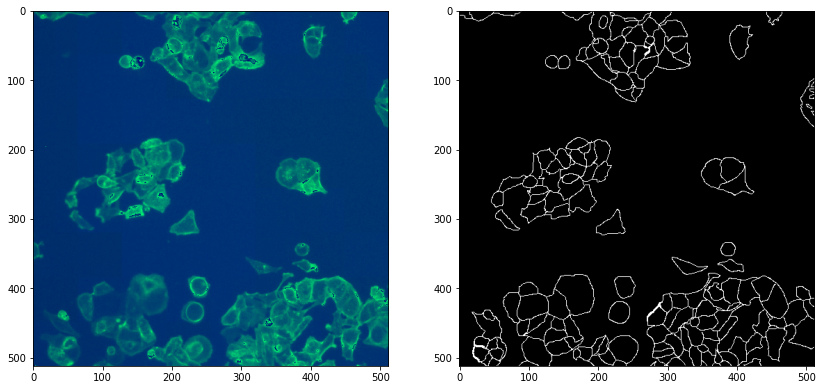

In [ ]:
first_batch = training_generator[1]
img = first_batch[0][0]
mask = first_batch[1][0]
plt.figure(figsize=(14, 10))
plt.subplot(1,2,1)
print(img.shape, np.min(img), np.max(img))
plt.imshow(img)
plt.subplot(1,2,2)
print(mask.shape, np.min(mask), np.max(mask))
plt.imshow(mask, 'gray')

In [ ]:
from keras import Model
from keras.optimizers import Adam, RMSprop

from tensorflow.keras import layers
from keras.models import Model
from keras.layers.merge import concatenate
from keras.layers import (Input,
                          Conv2D,
                          MaxPooling2D,
                          UpSampling2D,
                          Dropout,
                          Concatenate,
                          BatchNormalization,
                          Activation,
                          Conv2DTranspose,
                          Add)

from keras.losses import binary_crossentropy
from keras import backend as K
from torch import nn

In [ ]:
def ResNet_block(input_x, input_y, filters):
    x = Conv2D(filters, (3, 3), (1, 1), padding='same')(input_x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), (1, 1), padding='same')(x)

    y = Add()([x, input_y])

    x = Conv2D(filters, (3, 3), (1, 1), padding='same')(y)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), (1, 1), padding='same')(x)

    x = Add()([x, y])

    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    return x

def Enc_block(input, start_neurons, dropout_ratio):
    y = Conv2D(start_neurons, (3, 3), padding="same")(input)
    x = BatchNormalization()(y)
    x = Activation('relu')(x)

    y = ResNet_block(x, y, start_neurons)
    x = MaxPooling2D((2, 2))(y)
    x = Dropout(dropout_ratio)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x, y

def Dec_block(input_x, input_y, start_neurons, dropout_ratio):
    x = Conv2DTranspose(start_neurons, (3, 3), strides=(2, 2), padding="same")(input_x)
    x = concatenate([x, input_y])

    x = Dropout(dropout_ratio)(x)
    y = Conv2D(start_neurons, (3, 3), padding="same")(x)
    x = BatchNormalization()(y)
    x = Activation('relu')(x)

    x = ResNet_block(x, y, start_neurons)

    return x

def Unet_model(some_shape, start_n=12, dropout_ratio=0.5):
    input = Input(shape=some_shape + (3,))

    x16, y16 = Enc_block(input, start_n, 0)
    x32, y32 = Enc_block(x16, start_n*2, dropout_ratio)
    x64, y64 = Enc_block(x32, start_n*4, dropout_ratio)
    x128, y128 = Enc_block(x64, start_n*8, dropout_ratio)
    x256, y256 = Enc_block(x128, start_n*16, dropout_ratio)
    x512, y512 = Enc_block(x256, start_n*32, dropout_ratio)

    x1024, y1024 = Enc_block(x512, start_n*64, dropout_ratio)

    z512 = Dec_block(y1024, y512, start_n*32, dropout_ratio)
    z256 = Dec_block(z512, y256, start_n*16, dropout_ratio)
    z128 = Dec_block(z256, y128, start_n*8, dropout_ratio)
    z64 = Dec_block(z128, y64, start_n*4, dropout_ratio)
    z32 = Dec_block(z64, y32, start_n*2, dropout_ratio)
    z16 = Dec_block(z32, y16, start_n, 0)

    output = Conv2D(1, (1 ,1), padding="same", activation="sigmoid")(z16)
    model = Model(input, output)

    return model

In [ ]:
# interesting about loss:
# https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch
# https://github.com/keras-team/keras/issues/10890
# https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/64943
# https://github.com/keras-team/keras/issues/6538

def DiceBCELogLoss(targets, inputs, smooth=1e-6, dice_weight=25):
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE =  K.binary_crossentropy(targets, inputs)
    intersection = K.sum(targets * inputs)    
    union = K.sum(targets) + K.sum(inputs)
    Dice_coef = (2. * intersection + smooth) / (union + smooth)
    Dice_loss = -dice_weight * K.log(Dice_coef)
    Dice_BCE = BCE + Dice_loss
    return Dice_BCE

def true_iou(prediction, ground_truth, smooth=1e-6, treshold=0.5):
    y_true = K.flatten(ground_truth)
    y_pred = K.flatten(prediction)
    ones_f = K.ones_like(y_true)
    zeros_f = K.zeros_like(y_pred)

    y_true_f = K.switch(K.greater(y_true, treshold), ones_f, zeros_f)
    y_pred_f = K.switch(K.greater(y_pred, treshold), ones_f, zeros_f)

    intersection = K.sum(K.switch(y_true_f * y_pred_f, ones_f, zeros_f))
    union = K.sum(K.switch(y_true_f + y_pred_f, ones_f, zeros_f)) 
    return (intersection + smooth) / (union + smooth)

def calc_iou(prediction, ground_truth, smooth=1e-6, treshold=0.5):
    if prediction.ndim > 3:
        prediction = np.squeeze(prediction)
    if ground_truth.ndim > 3:
        ground_truth = np.squeeze(ground_truth)

    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > treshold, ground_truth[i] > treshold).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > treshold, ground_truth[i] > treshold).astype(np.float32).sum()
    return (intersection + smooth) / (union + smooth)

In [ ]:
model = Unet_model(img_shape)

model.compile(optimizer=Adam(lr=1e-3), #RMSprop(lr=0.001, rho=0.9, epsilon=1e-6)
                  loss=DiceBCELogLoss,
                  metrics=[true_iou])

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 12) 336         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 12) 48          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 12) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, TerminateOnNaN, ReduceLROnPlateau

class TerminateOnBaseline(Callback):
    def __init__(self, monitor='acc', baseline=0.9, verbose=0):
        super(TerminateOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = baseline
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get(self.monitor)
        if acc is not None:
            if acc >= self.baseline:
                if self.verbose > 0:
                    print('Epoch %d: Reached baseline, terminating training' % (epoch))
                self.model.stop_training = True

In [ ]:
epochs = 80

callbacks = [
    EarlyStopping(patience=15, 
                  verbose=1, 
                  monitor='val_true_iou', 
                  restore_best_weights=True, 
                  mode='max'),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    TerminateOnBaseline(monitor='val_true_iou', baseline=0.29, verbose=1),
    TerminateOnNaN() # https://github.com/keras-team/keras/issues/2134
]

history = model.fit_generator(generator=training_generator,
                    validation_data=testing_generator,
                    epochs=epochs,
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/80
14/14 [==============================] - 252s 18s/step - loss: 53.7909 - true_iou: 0.1096 - val_loss: 52.9818 - val_true_iou: 0.1153
Epoch 2/80
14/14 [==============================] - 253s 18s/step - loss: 49.9218 - true_iou: 0.1225 - val_loss: 50.0570 - val_true_iou: 0.1265
Epoch 3/80
14/14 [==============================] - 250s 18s/step - loss: 45.6897 - true_iou: 0.1219 - val_loss: 58.1442 - val_true_iou: 0.0274
Epoch 4/80
14/14 [==============================] - 254s 18s/step - loss: 49.7492 - true_iou: 0.1175 - val_loss: 64.9812 - val_true_iou: 0.0525
Epoch 5/80
14/14 [==============================] - 250s 18s/step - loss: 48.4792 - true_iou: 0.1166 - val_loss: 61.2234 - val_true_iou: 0.0511
Epoch 6/80
14/14 [==============================] - 251s 18s/step - loss: 45.1671 - true_iou: 0.1335 - val_loss: 91.6818 - val_true_iou: 0.0016
Epoch 7/80
14/14 [==============================] - ETA: 0s - loss: 43.8017 - true_iou: 0.1481 
Epoch 00007: ReduceLROnPlateau reducing 

Text(0.5, 0, 'epoch')

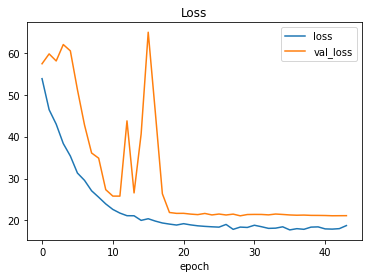

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

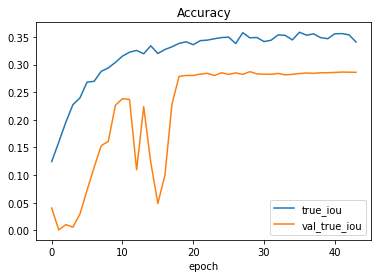

In [ ]:
plt.plot(history.history['true_iou'])
plt.plot(history.history['val_true_iou'])
plt.legend(['true_iou', 'val_true_iou'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [ ]:
predictions = model.predict(testing_X)

(512, 512, 1) 6.223296e-05 0.9999999
Predicted IOU: 0.3101328868594593


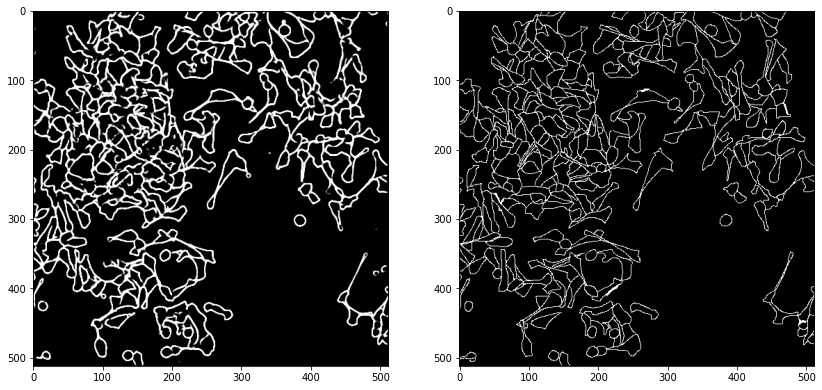

In [ ]:
import random

num = random.randint(0, len(predictions) - 1)
pred = predictions[num]
#binarize_img(pred)
print(pred.shape, np.min(pred), np.max(pred))

truth = testing_y[num]
pred_iou = calc_iou(pred.reshape(img_shape), truth)

plt.figure(figsize=(14, 10))
plt.subplot(1,2,1)
plt.imshow(pred.reshape(img_shape), 'gray')
plt.subplot(1,2,2)
plt.imshow(truth, 'gray')
print('Predicted IOU:', pred_iou)

In [ ]:
iou = calc_iou(predictions, testing_y)
#_, iou_tensor = model.evaluate(testing_X, testing_y, verbose=0) # для проверки формулы
#np.testing.assert_array_almost_equal(iou, iou_tensor, 6, 'IOU implementation is not correct')
print('IOU val accuraccy: %.2f' % iou)

IOU val accuraccy: 0.29
